In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

%matplotlib inline

## Sampling


In [2]:
def get_sample(arr, n_iter=None, sample_size=50):
    """ Return a random sample from arr. Here, arr is only
    shuffled when necessary. 
    
    Parameters
    ----------
    arr : np.array
        Array from which to take sample
    n_iter : int
        Sample number (for taking multiple samples)
    sample_size : int
        Size of sample to take
    
    Returns
    -------
    sample : np.array
        Sample from arr
    """
    np.random.seed(n_iter)
    m = arr.shape[0]

    start_idx = (n_iter * sample_size) % m

    if start_idx + sample_size >= m:
        np.random.shuffle(arr)
        start_idx = 0

    return arr[start_idx : start_idx + sample_size]


def collect_samples(arr, sample_size, n_samples):
    """ Return a collection of samples from arr.
    
    Parameters
    ----------
    arr : np.array
        Array from which to take samples
    sample_size : int
        Size of each sample
    n_samples : int
        The number of samples to be taken from arr

    Returns
    -------
    samples : np.array, shape=[n_samples, sample_size]
        Sample array
    """
    m = arr.shape[0]
    samples = np.zeros((n_samples, sample_size), np.int64)

    for sample_n in range(n_samples):

        sample = get_sample(arr, n_iter=sample_n, sample_size=sample_size)
        samples[sample_n, :] = sample

    return samples


## Dissimilarity/adjacency matrices


In [5]:
def dissim(X, x):
    """ Return normalised, pointwise dissimilarity between
    x and all points in X.
    
    Parameters
    ----------
    X : np.array, shape=[N, m]
        Array from which to take dissimilarities
    x : np.array, shape=[m,]
        Vector (datapoint) to compare with X
    
    Returns
    -------
    dissims : np.array, shape=[N,]
        Normed-dissimilarity vector
    """
    dissims = np.sum(X != x, axis=1) / len(x)
    return dissims


def build_dissim_matrix(X, Y):
    """ Constructs a matrix with shape |X| by |Y| where
    the i'th row is the dissimilarity of X[i] with each
    element of Y.

    Parameters
    ----------
    X, Y : np.array
        The sets of points to build the matrix with
    
    Returns
    -------
    dissim_matrix : np.array, shape=[|X|, |Y|]
        Dissimilarity matrix of X and Y
    """
    N_X, m_X = X.shape
    N_Y, m_Y = Y.shape
    dissim_matrix = np.empty((N_X, N_Y))

    if m_X == m_Y:
        for i, x in enumerate(X):
            dissim_matrix[i, :] = dissim(Y, x)
        return dissim_matrix
    raise ValueError(
        f"Points in X and Y must be of the same size. \
                       \n {m_X} != {m_Y}"
    )


def get_similar_pairs(X_bar, X_til, beta_max, res, sample_idx, sample_size):
    """ Return a dataframe of similar pairs of points from X*Y. 
    
    Parameters
    ----------
    X_bar, X_til : np.array
        The sets from which to take pairs
    beta : float
        A quality measure indicating how similar points must be
    sample_idx : int
        Indicator for which number sample a pair was added
    
    Returns
    -------
    pair_df : pd.DataFrame
        A dataframe detailing the indices of the pairs found, beta, the
        sample number, and the dissimilarity of each pair.
    """

    pair_dfs = []
    dissim_matrix = build_dissim_matrix(X_bar.values, X_til.values)

    adjacency_matrices = [
        (beta, np.where(dissim_matrix <= beta, 1, 0))
        for beta in np.linspace(0, beta_max, res)
    ]

    for beta, adjacency_matrix in adjacency_matrices:
        row_idxs, col_idxs = np.where(adjacency_matrix == 1)
        idx_pairs = zip(row_idxs, col_idxs)

        for idxs in idx_pairs:

            X_bar_idx = X_bar.index[idxs[0]]
            X_til_idx = X_til.index[idxs[1]]

            pair_df = pd.DataFrame(
                {
                    "beta_min": beta,
                    "sample_idx": [sample_idx],
                    "X_bar_idx": X_bar_idx,
                    "X_til_idx": X_til_idx,
                    "dissim": dissim_matrix[idxs[0], idxs[1]],
                    "sample_size": sample_size,
                }
            )

            pair_dfs.append(pair_df)

    return pd.concat(pair_dfs, ignore_index=True)


In [101]:
def pack_out(n_samples, sample_idx_df):

    packed_out = np.zeros(n_samples)
    nonzero_idxs = np.unique(sample_idx_df)
    no_pairs = np.bincount(sample_idx_df)

    for idx, no_pair in zip(nonzero_idxs, no_pairs):
        packed_out[idx] = no_pair

    return packed_out


In [6]:
df = pd.read_csv("zoo.csv")

catsize = df[df.catsize == 1].drop("catsize", axis=1)
notcatsize = df[df.catsize != 1].drop("catsize", axis=1)


In [177]:
n_samples = 10
sample_size = 25

cat_sample_idxs = collect_samples(
    np.array(catsize.index), sample_size=sample_size, n_samples=n_samples
)
notcat_sample_idxs = collect_samples(
    np.array(notcatsize.index), sample_size=sample_size, n_samples=n_samples
)


In [178]:
cat_dfs = []

for idxs in cat_sample_idxs:
    cat_dfs.append(df.iloc[idxs])

notcat_dfs = []

for idxs in notcat_sample_idxs:
    notcat_dfs.append(df.iloc[idxs])


In [40]:
pair_dfs = []

for i, cat, notcat in zip(list(range(n_samples)), cat_dfs, notcat_dfs):
    pair_df = get_similar_pairs(
        cat, notcat, beta_max=0.5, res=51, sample_idx=i, sample_size=sample_size
    )
    pair_dfs.append(pair_df)


In [75]:
result = pd.concat(pair_dfs, ignore_index=True).reset_index()


In [96]:
plot_result = result[result.beta_min == 0.25].drop_duplicates(
    ["X_bar_idx", "X_til_idx"]
)


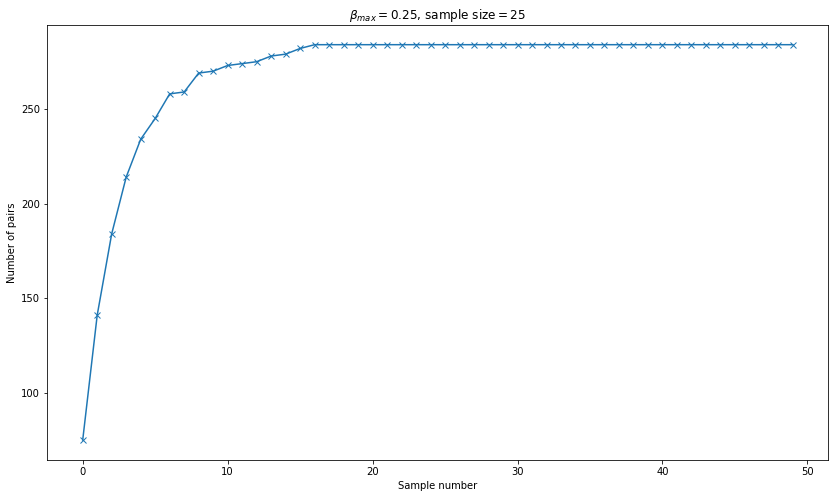

In [159]:
fig = plt.figure(figsize=(14, 8))

plt.plot(
    [x for x in range(n_samples)],
    np.cumsum(pack_out(n_samples, plot_result.sample_idx)),
    "x-",
)

plt.xlabel("Sample number")
plt.ylabel("Number of pairs")
plt.title(r"$\beta_{max} = 0.25$, sample size$= 25$")


In [165]:
df = pd.read_csv("mushrooms.csv")

edible = df[df["class"] == "e"].drop("class", axis=1)
poisonous = df[df["class"] == "p"].drop("class", axis=1)
